In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import importlib

from mesa.batchrunner import BatchRunner

import src.model

In [2]:
# run this cell to re-import the Model class
importlib.reload(src.model);

# Single run

In [3]:
# setup parameters
time_step = 0.1
n_steps = 1000

model = src.model.Model(
    length=1000,
    n_lanes=2,
    density=20,
    fraction_autonomous=0,
    max_speed_mu=120,
    max_speed_sigma=0,
    min_spacing=2,
    car_acc=33 / 10,
    car_dec=33 / 5,
    p_slowdown=0.1,
    bias_right_lane=1,
    time_step=time_step,
    seed=None,
    verbose=0)

# run simulation for `n_steps`
def run():
    for i in range(n_steps):
        model.step()
        
%time run()

Wall time: 13.2 s


Text(0,0.5,'Flow $k$')

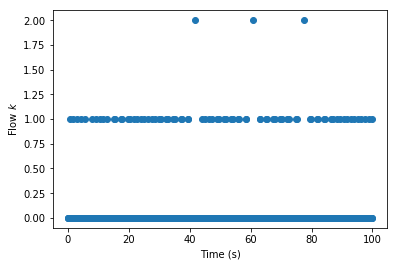

In [4]:
# plot the density over time
df = model.data.get_model_vars_dataframe()
plt.plot(df.index * time_step, df.Flow, "o")
plt.xlabel("Time (s)")
plt.ylabel("Flow $k$")

# Batch run

Note that the `model_reporters` and `agent_reporters` of `BatchRunner` (unlike the `DataCollector`) won’t collect the data every step of the model, but only at the end of each run. Because of this the following function is used to extract the relevant data from the models datacollector.

In [5]:
def get_density(model, initialisation_steps=0):
    """Extract density from model datacollector.
    
    Parameters
    ----------
    model
    initialisation_steps -- number of initial steps to exclude from the mean.
    """
    # time-evolution of density
    densities = model.data.get_model_vars_dataframe().Density
    # return the mean
    return densities[initialisation_steps:].mean()
    
def get_flow(model, initialisation_steps=0, flow_per=10):
    """Extract flow from model datacollector.
    
    Parameters
    ----------
    model
    initialisation_steps -- number of initial steps to exclude from the mean.
    flow_per -- return the flow per this number of time_steps.
    """
    # time-evolution of flow
    flows = model.data.get_model_vars_dataframe().Flow
    # return the mean
    return flows[initialisation_steps:].mean() * flow_per

In [6]:
# setup parameters
n_lanes = [1, 2]
density = np.linspace(10, 60, 10)
fraction_autonomous = [0]
n_steps = 1000
initialisation_steps = 500

fixed_params = {
    "length": 1000,
    "max_speed_mu": 120,
    "max_speed_sigma": 0,
    "min_spacing": 1,
    "min_distance_mu": 2,
    "min_distance_sigma": 0,
    "car_acc": 33 / 10,
    "car_dec": 33 / 5,
    "p_slowdown": 0.2,
    "bias_right_lane": 1,
    "time_step": 0.1,
    "verbose": 0
}
variable_params = {
    "n_lanes": n_lanes,
    "density": density,
    "fraction_autonomous": fraction_autonomous
}

# create and run `BatchRunner`
batch_run = BatchRunner(src.model.Model,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=2,
                        max_steps=n_steps,
                        model_reporters={
                            "flow": lambda x: get_flow(x, initialisation_steps)
                        },
                        agent_reporters={},
                        display_progress=True)

print("Total iterations: ", np.product([len(var) for var in batch_run.variable_parameters.values()]) * batch_run.iterations)
sys.stdout.flush()
batch_run.run_all()

Total iterations:  40


40it [18:55, 92.92s/it]


In [7]:
# get the dataframe and select the relevant columns
df = batch_run.get_model_vars_dataframe()
df = df[["length", "n_lanes", "density", "fraction_autonomous", "flow"]]
df

,length,n_lanes,density,fraction_autonomous,flow
0,1000,1,10.000000,0,0.34
1,1000,1,10.000000,0,0.32
2,1000,1,15.555556,0,0.54
3,1000,1,15.555556,0,0.52
4,1000,1,21.111111,0,0.70
5,1000,1,21.111111,0,0.68
6,1000,1,26.666667,0,0.80
7,1000,1,26.666667,0,0.80
8,1000,1,32.222222,0,0.78
9,1000,1,32.222222,0,0.78


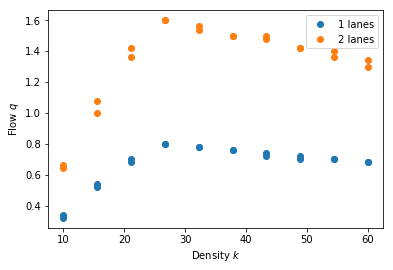

In [8]:
# plot flow rate versus vehicle density 
fig, ax = plt.subplots(1, 1)
for n_lane in n_lanes:
    data = df[df.n_lanes == n_lane]
    ax.plot(data.density, data.flow, "o", label="{} lanes".format(n_lane))

ax.set_xlabel("Density $k$")
ax.set_ylabel("Flow $q$")    
ax.legend()

# Sensitivity Analysis OFAT

In [1]:
%matplotlib inline
from SALib.sample import saltelli
from src.model import Model
from src.car import Car
from mesa.batchrunner import BatchRunner
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [5]:
n_steps = 100
initialisation_steps = 0

# We define our variables and bounds
problem = {
    'num_vars': 4,
    'names': ['p_slowdown', 'n_lanes', 'density', 'fraction_autonomous'],
    'bounds': [[0.005, 0.2], [1, 5], [20, 50], [0, 1]]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 10
max_steps = 100
distinct_samples = 15 

# Set the outputs
model_reporters = {"flow": lambda x: get_flow(x, initialisation_steps)}

data = {}

for i, var in enumerate(problem['names']):
    # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
    samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
    
    # acommidate for integers
    if var == 'n_lanes':
        samples = np.linspace(*problem['bounds'][i], num=5, dtype=int)
        
    batch = BatchRunner(Model, 
                        max_steps=max_steps,
                        iterations=replicates,
                        variable_parameters={var: samples},
                        model_reporters=model_reporters,
                        display_progress=True)
    
    batch.run_all()
    
    data[var] = batch.get_model_vars_dataframe()


150it [01:51,  1.35it/s]
50it [04:07,  9.25s/it]
150it [02:36,  1.90s/it]
150it [01:51,  1.34it/s]


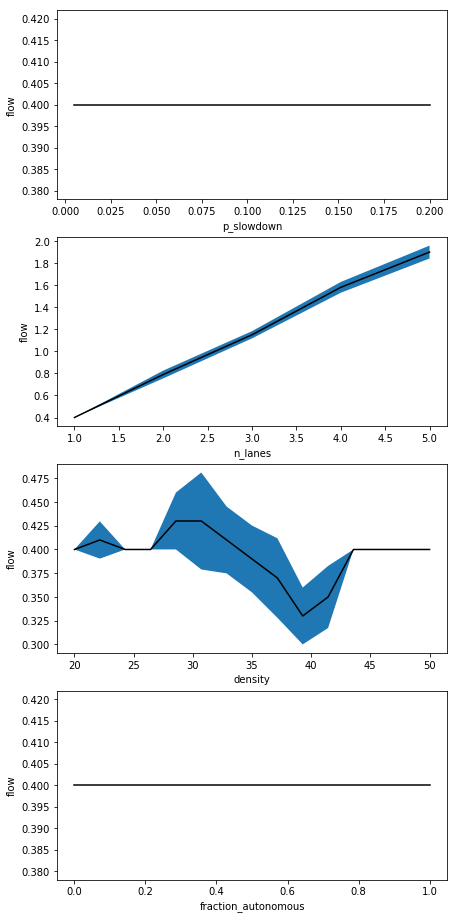

In [6]:
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err)

    ax.set_xlabel(var)
    ax.set_ylabel(param)

def plot_all_vars(df, param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(len(param), figsize=(7, 4*len(param)))
    
    for i, var in enumerate(problem['names']):
        plot_param_var_conf(axs[i], data[var], var, param, i)

        
## Wat moet hier ... op de plek van 'flow'         
for param in model_reporters:
    plot_all_vars(data, param)
    plt.show()